In [1]:
import pandas as pd
from plotnine import *
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import sklearn

ModuleNotFoundError: No module named 'pandas'

# Task 1: Exploration {-}
### 1 {-}
After the dataset is loaded, we can take a look at the first 10 rows of data to develop our intuition of the dataset. The target has been added as a column named progression into a dataframe with the rest of the data.

In [2]:
diabetes = sklearn.datasets.load_diabetes()
target = diabetes.target
df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
df["progression"] = target

nulls = df.isnull().sum()
if nulls.sum() > 0:
    print(nulls)


df.head(10)


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,progression
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0
5,-0.092695,-0.044642,-0.040696,-0.019442,-0.068991,-0.079288,0.041277,-0.076395,-0.041176,-0.096346,97.0
6,-0.045472,0.050680,-0.047163,-0.015999,-0.040096,-0.024800,0.000779,-0.039493,-0.062917,-0.038357,138.0
7,0.063504,0.050680,-0.001895,0.066629,0.090620,0.108914,0.022869,0.017703,-0.035816,0.003064,63.0
8,0.041708,0.050680,0.061696,-0.040099,-0.013953,0.006202,-0.028674,-0.002592,-0.014960,0.011349,110.0
9,-0.070900,-0.044642,0.039062,-0.033213,-0.012577,-0.034508,-0.024993,-0.002592,0.067737,-0.013504,310.0


### 2 {-}
There are 442 rows, each with 11 columns, and of those columns there are 10 attribute variables and one target variable. A quick glance at the data shows it has been processed in someway, and looking at the dataset [documentation](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset) reveals that "each of these 10 feature variables have been mean centered and scaled by the standard deviation times the square root of n_samples". Based on the [loading function](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html), the features are real values between -0.2 and 0.2 and the target is an integer between 25 and 346. The target is stated to represent disease progression after a one year baseline. The dataset out of the box appears clean such that no values are missing and all the attributes have been normalized or processed in some manner. The features themselves correspond to data taken from patients about their health and demographic information between age, sex, blood pressure, and blood measurements.

To investigate the data further, let's look at a correlation matrix of the dataset.

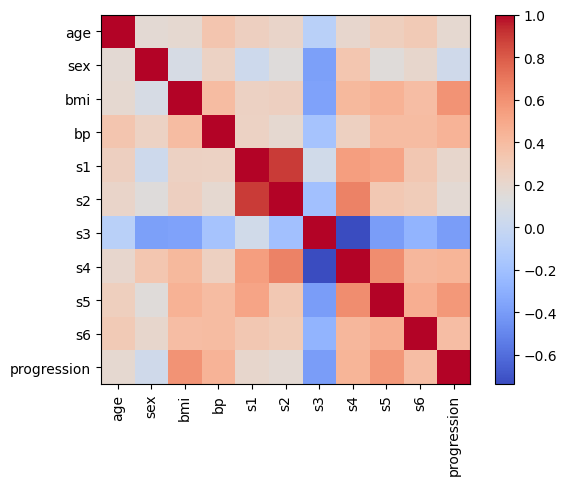

In [3]:
corrs = df.corr()
heatmap = plt.imshow(corrs, cmap='coolwarm')
plt.colorbar(heatmap)
plt.xticks(range(len(corrs.columns)), corrs.columns, rotation=90)
plt.yticks(range(len(corrs.columns)), corrs.columns)
plt.show()

This gives us a picture about some correlations in the data. Notably S3 has weak correlation with the rest of the features. In terms of correlations with the target, we see the most notable correlation involving s5 and bmi on the progression of the disease. Furthermore, we see notable correlations in the features such as (s4, s2), (s5, s4), and a very strong correlation with (s2, s1).

### 3 {-}
To proceed to training, the data will be randomly split as a 80/20 split. This will be done by extracting rows of data randomly from the dataset until a count matching 80% is met, and the remainder will be used for testing.

In [4]:
train, test = train_test_split(df, test_size=0.2, random_state=54)

y_train = train["progression"]
X_train = train.drop(["progression"], axis=1)
y_test = test["progression"]
X_test = test.drop(["progression"], axis=1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Task 2: Linear Regression Model {-}

### 2.1 {-}


In [5]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
feature_df = pd.DataFrame(index=diabetes.feature_names, columns=["coef"])


for feature, coef in zip(diabetes.feature_names, lr.coef_):
    feature_df.loc[feature, "coef"] = coef

feature_df.head()

,coef
age,-0.402332
sex,-10.887657
bmi,25.723753
bp,16.215056
s1,-44.787686


### 2.2 {-}

In [6]:
y_pred = lr.predict(X_test, )
full_mse = mean_squared_error(y_test, y_pred)
full_r2 = r2_score(y_test, y_pred)
#print(f"MSE: {full_mse:.2f}, R²: {full_r2:.2f}") # MSE: 5075.28, R²: 0.05

/home/koris/Documents/data/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names


We see an MSE of 5075.28 and an R²: 0.05

# Task 3: Implement Recursive Feature Elimination {-}

### 3.1/3.2/3.3 {-}

In [7]:
train_rsq = []
test_rsq = []
X = pd.DataFrame(data=diabetes.data, columns=diabetes.feature_names)
y = diabetes.target

rfe_df = pd.DataFrame(columns=diabetes.feature_names)
ranks_df = pd.DataFrame(columns=diabetes.feature_names)
models = []
scaled_X_tests = []
rankings = []

for n in range(1, 11):
    rfe = RFE(estimator=lr, n_features_to_select=n)
    rfe.fit(X_train_scaled, y_train)

    selected_features = X.columns[rfe.support_]
    eliminated_features = X.columns[~rfe.support_]
    X_train_selected = X_train_scaled[:, rfe.support_]
    X_test_selected = X_test_scaled[:, rfe.support_]
    scaled_X_tests.append(X_test_selected)

    lr_selected = LinearRegression()
    lr_selected.fit(X_train_selected, y_train)
    models.append(lr_selected)

    for feature, coef in zip(selected_features, lr_selected.coef_):
        rfe_df.loc[n, feature] = coef
        feature_idx = diabetes.feature_names.index(feature)
        ranks_df.loc[n, selected_features] = rfe.ranking_[feature_idx]

    rankings.append(rfe.ranking_)
   
    train_score = lr_selected.score(X_train_selected, y_train)
    test_score = lr_selected.score(X_test_selected, y_test)
    train_rsq.append(train_score)
    test_rsq.append(test_score)


train_rsq = np.array(train_rsq)
test_rsq = np.array(test_rsq)
train_rsq = pd.DataFrame(train_rsq, columns=['rsq'])
train_rsq["type"] = "train"
train_rsq["n"] = np.arange(1, 11).astype(int)
test_rsq = pd.DataFrame(test_rsq, columns=['rsq'])
test_rsq["type"] = "test"
test_rsq["n"] = np.arange(1, 11).astype(int)

df_rsq = pd.concat([train_rsq, test_rsq], axis=0)

### 3.4 {-}

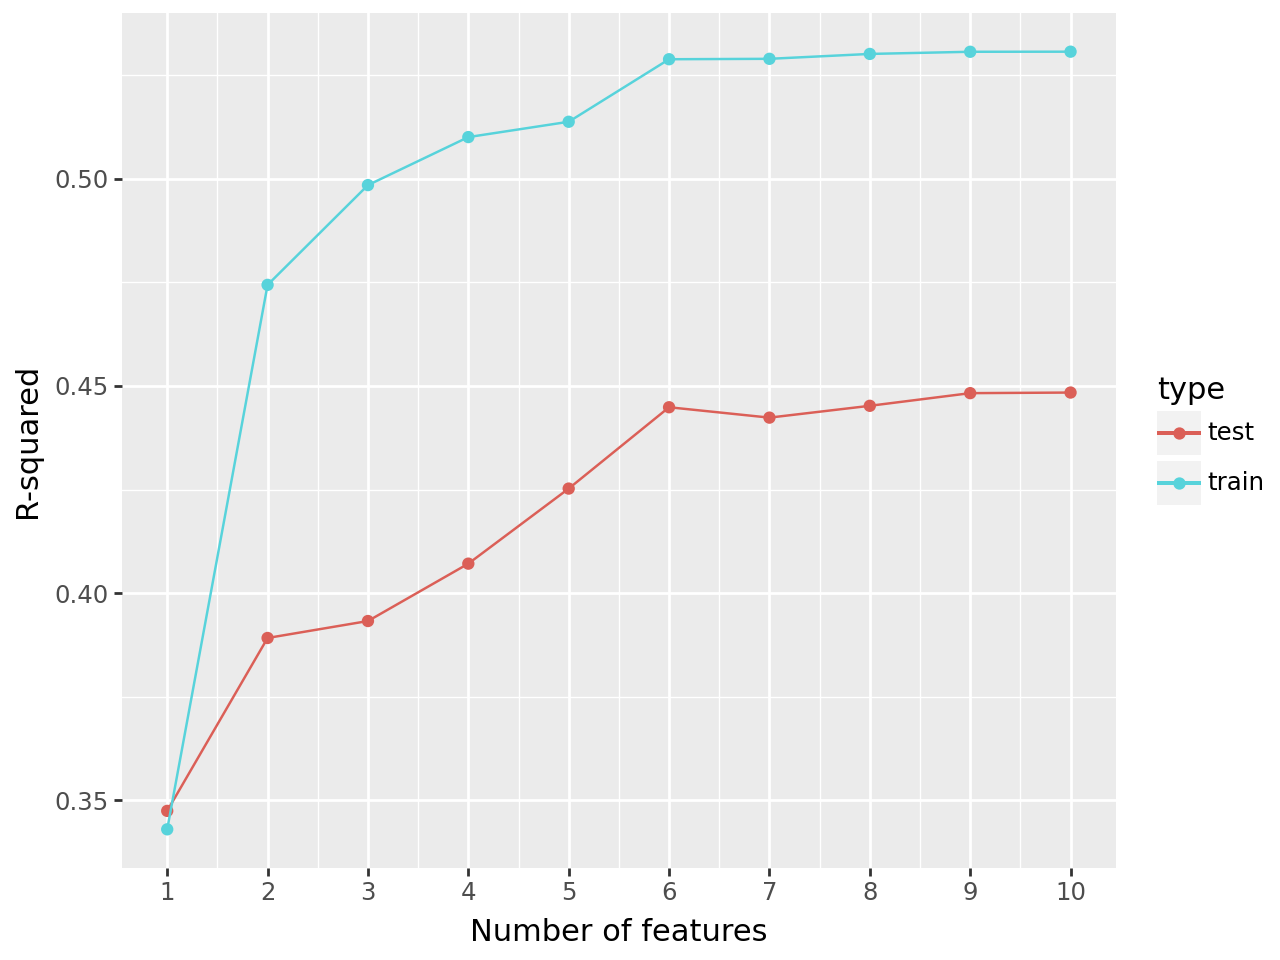

In [8]:
plot = ggplot(df_rsq, aes(x="n", y="rsq", color="type")) +\
    geom_point() +\
    geom_line() +\
    xlab("Number of features") +\
    ylab("R-squared") +\
    scale_x_continuous(breaks=np.arange(1, 11).astype(int))
plot.show()

### 3.5 {-}
The optimal number of features is 6.

# Task 4: Analyze Feature Importance {-}

### 4.1 {-}

In [9]:
rfe_df = rfe_df.replace(np.nan, "-")
rfe_df

/tmp/ipykernel_140172/3308371037.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
1,-,-,45.650347,-,-,-,-,-,-,-
2,-,-,31.611380,-,-,-,-,-,31.552411,-
3,-,-,28.007185,13.631823,-,-,-,-,27.762012,-
4,-,-,28.550848,13.833697,-9.855891,-,-,-,32.577782,-
5,-,-,27.106807,13.974239,-21.949705,12.079356,-,-,35.765062,-
6,-,-10.636346,25.861744,16.072454,-32.420861,21.862475,-,-,39.728338,-
7,-,-10.523376,25.891648,16.028773,-37.379165,26.063952,2.195756,-,41.870962,-
8,-,-10.816302,25.971188,16.503181,-44.864372,28.461003,9.122351,8.092169,42.596858,-
9,-,-10.944739,25.727677,16.134032,-44.775003,28.249702,8.891999,7.690111,42.091842,2.110479
10,-0.402332,-10.887657,25.723753,16.215056,-44.787686,28.319852,8.925173,7.660856,42.138026,2.168386


### 4.2 {-}
The three most important features for predicting the progression of diabetes appear to be bmi, blood pressure, and s5. This alligns with what we saw in the correlation matrix. The most significant predictor is bmi closely followed by s5. 

### 4.3 {-}

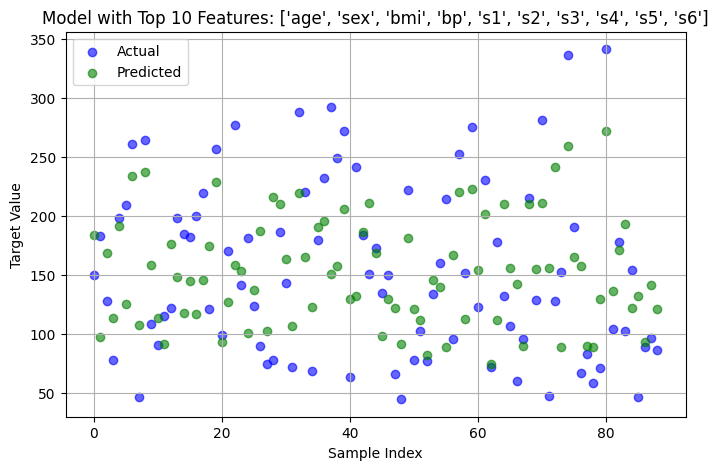

In [10]:
model = models[0]
y_pred_initial = model.predict(scaled_X_tests[0])

plt.figure(figsize=(8, 5))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual', alpha=0.6) 
plt.scatter(range(len(y_pred_initial)), y_pred_initial, color='green', label='Predicted', alpha=0.6)
plt.title(f"Model with Top {10} Features: {list(selected_features)}")
plt.xlabel("Sample Index")
plt.ylabel("Target Value")
plt.legend()
plt.grid()
plt.show()

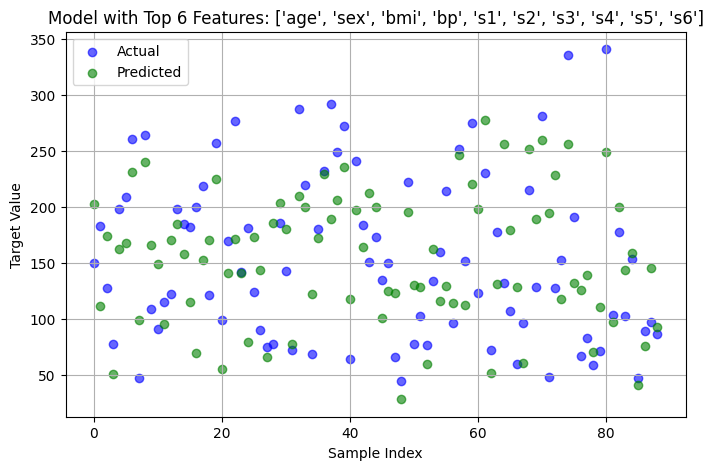

In [11]:
model = models[5]
y_pred_initial = model.predict(scaled_X_tests[5])

plt.figure(figsize=(8, 5))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual', alpha=0.6) 
plt.scatter(range(len(y_pred_initial)), y_pred_initial, color='green', label='Predicted', alpha=0.6)
plt.title(f"Model with Top {6} Features: {list(selected_features)}")
plt.xlabel("Sample Index")
plt.ylabel("Target Value")
plt.legend()
plt.grid()
plt.show()

We can see pretty similar performance between the initial and final models. Both models perform pretty poorly and have similar values of R-squared as based on our earlier plot of model R-squared performance. The 6-featured model, by virtue of being simpler while keeping the same performance, is a better fit for the data.

# Task 5: Reflection {-}

### 3.1 {-}
RFE appears to be a very effective method for iteratively selecting important features. It's ease of use when wanting to target a specific number of features provides flexibility of tuning. Given situations where the number of features is not large, RFE seems like a good choice.

### 3.2 {-}
LASSO compared to RFE includes a penalty term which means it might be better for optimizing for sparsity. It might also be a better choice given large numbers of features when compared to RFE as it doesn't have to recursively iterate to find the best features. Lasso does however require plugging in alpha values to test for the best alpha, which is not as intuitive. 

### 3.3 {-}
BMI, BP, and S5 seem to be the most important features for predicting diabetes. Intuitively, body mass index and blood pressure should be assocaited with one's health, and one might even go as far as to assume that an increased BMI or BP would be a sign of worse health, so their association with diabetes is not surprising. S5 is meant to be serum triglycerides, which according to [mayo clinic](https://www.mayoclinic.org/diseases-conditions/high-blood-cholesterol/in-depth/triglycerides/art-20048186) is a measure of a certain type of fat in the blood, so it'd make sense how it might be associated with diabetes. There is a blood sugar feature (s6), however it did not have a positive association with diabetes, which was a surprising find.